In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import torch
import math
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

datasetPath = "/content/drive/MyDrive/astro_dataset_maxia"
testPath = "/content/drive/MyDrive/astro_dataset_maxia/test"
trainingPath = "/content/drive/MyDrive/astro_dataset_maxia/training"
validationPath = "/content/drive/MyDrive/astro_dataset_maxia/validation"

Making sure to set device to gpu, as colab has some issues doing so normally

In [9]:

deviceLocal = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

try:
    torch.multiprocessing.set_start_method('spawn', force=True)
    print("Multiprocessing start method set to 'spawn'.")
except RuntimeError:

    print("Multiprocessing start method is already set.")


g_cuda = None
if deviceLocal.type == 'cuda':
    g_cuda = torch.Generator(device=deviceLocal)
    g_cuda.manual_seed(42)
    print(f"CUDA Generator created for device: {deviceLocal}")
else:
    print("WARNING: CUDA not found. Check Colab runtime settings.")

torch.set_default_device(deviceLocal)


Multiprocessing start method set to 'spawn'.
CUDA Generator created for device: cuda:0


Making sure to do some image preprocessing, that is common for all custom CNN, such as resizing, crop and converting to Tensor. Done on train, validation and test sets.

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(
    root=trainingPath,
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=validationPath,
    transform=val_test_transforms
)


test_dataset = datasets.ImageFolder(
    root=testPath,
    transform=val_test_transforms
)


print(f"Classes: {train_dataset.classes}")
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

batch_size = 32
numWorkers = 4



Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Train samples: 2416, Validation samples: 658, Test samples: 345


In [12]:
#Creating DataLoaders

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers= numWorkers,
    generator=g_cuda
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers= numWorkers,
    generator=g_cuda
)


test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers= numWorkers,
    generator=g_cuda
)






CNN with 3 convolutional layers and one linear output layer

In [13]:
class myCNN(nn.Module):
  def __init__(self, num_classes):
    super(myCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels= 24, out_channels= 48, kernel_size = 3, padding = 1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size= 2, stride = 2)

    self.conv3 = nn.Conv2d(in_channels= 48, out_channels= 96, kernel_size = 3, padding = 1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size= 2, stride = 2)


    self.fc = nn.Linear(96 * 28 * 28, num_classes)



  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.pool3(self.relu3(self.conv3(x)))

    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x



num_classes = len(train_dataset.classes)
model = myCNN(num_classes= num_classes)

model.to(deviceLocal)



myCNN(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=75264, out_features=12, bias=True)
)

Hyper parameter tuning, testing 9 different combinations of parameters and testing on different epoch to find the one with best validation accuracy

In [ ]:
#Hyper parameter Tuning
learning_rate = [0.0001, 0.001, 0.01]
weight_decay = [0.0, 0.001, 0.0001]
data_schema= {
    "Learning Rate": 'float64' ,
    "Weight Decay": 'float64',
    "Epoch": 'int64',
    "Training Accuracy": 'float64',
    "Validation Accuracy" : 'float64'
    }


df = pd.DataFrame(columns=data_schema.keys()).astype(data_schema)
rows = []
epochsInterest = [4, 8, 12]

# Number of training epochs
num_epochs = 12

for lr in learning_rate:
  for wd in weight_decay:

    model = myCNN(num_classes= num_classes)

    model.to(deviceLocal)
    #Loss function that is typically used for multi-class classification
    lossFunction = nn.CrossEntropyLoss()



    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)


    #Training Model
    for epoch in range(num_epochs):
      model.train()
      total_loss= 0
      train_correct = 0
      train_total = 0
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(deviceLocal), labels.to(deviceLocal)
        optimizer.zero_grad()
        outputs = model(inputs)
        current_loss = lossFunction(outputs, labels)

        # Backward pass and optimize
        current_loss.backward()
        optimizer.step()

        total_loss += current_loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

      epoch_loss = total_loss / len(train_dataset)
      train_accuracy = 100 * train_correct / train_total

      #Validation
      model.eval()
      val_loss= 0
      correct = 0
      total = 0
      with torch.no_grad():
        for inputs, labels in val_loader:
          inputs, labels = inputs.to(deviceLocal), labels.to(deviceLocal)
          outputs = model(inputs)
          valCurrent_loss = lossFunction(outputs, labels)
          val_loss+= valCurrent_loss.item() * inputs.size(0)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      val_epoch_loss = val_loss / len(val_dataset)
      val_accuracy = 100 * correct / total

      if (epoch + 1) in epochsInterest:

        new_row = {
        "Learning Rate": lr ,
        "Weight Decay": wd,
        "Epoch": epoch + 1,
        "Training Accuracy": train_accuracy,
        "Validation Accuracy" : val_accuracy
        }
        rows.append(new_row)

      print(f'Epoch {epoch+1}/{num_epochs} | '
            f'Train Loss: {epoch_loss:.4f} | '
            f'Train Acc: {train_accuracy:.2f}% | '
            f'Validation Loss: {val_epoch_loss:.4f} | '
            f'Validation Acc: {val_accuracy:.2f}%')


dataDf = pd.DataFrame(rows)
df = pd.concat([df, dataDf], ignore_index = True)
print(df)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/12 | Train Loss: 1.7139 | Train Acc: 46.48% | Validation Loss: 1.1563 | Validation Acc: 58.66%
Epoch 2/12 | Train Loss: 1.0930 | Train Acc: 66.72% | Validation Loss: 0.8278 | Validation Acc: 74.62%
Epoch 3/12 | Train Loss: 0.8951 | Train Acc: 73.10% | Validation Loss: 0.7627 | Validation Acc: 76.90%
Epoch 4/12 | Train Loss: 0.8147 | Train Acc: 75.17% | Validation Loss: 0.6478 | Validation Acc: 79.79%
Epoch 5/12 | Train Loss: 0.7427 | Train Acc: 77.65% | Validation Loss: 0.6721 | Validation Acc: 79.48%
Epoch 6/12 | Train Loss: 0.6836 | Train Acc: 78.44% | Validation Loss: 0.6325 | Validation Acc: 81.16%
Epoch 7/12 | Train Loss: 0.6163 | Train Acc: 81.83% | Validation Loss: 0.5882 | Validation Acc: 81.76%
Epoch 8/12 | Train Loss: 0.5909 | Train Acc: 81.75% | Validation Loss: 0.5488 | Validation Acc: 82.98%
Epoch 9/12 | Train Loss: 0.5456 | Train Acc: 83.98% | Validation Loss: 0.5267 | Validation Acc: 84.50%
Epoch 10/12 | Train Loss: 0.5441 | Train Acc: 82.62% | Validation Loss: 0

Model saved to spacePhotosModel.pth


From the above table we can see lr = 0.0010 and Weight Decay of 0.0001 with 12 epochs gave the best validation accuracy

In [14]:

model = myCNN(num_classes= num_classes)

model.to(deviceLocal)
#Loss function that is typically used for multi-class classification
lossFunction = nn.CrossEntropyLoss()


num_epochs = 12
optimizer = optim.Adam(model.parameters(), lr=0.0010, weight_decay = 0.0001)

#Training Model
for epoch in range(num_epochs):
  model.train()
  total_loss= 0
  train_correct = 0
  train_total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(deviceLocal), labels.to(deviceLocal)
    optimizer.zero_grad()
    outputs = model(inputs)
    current_loss = lossFunction(outputs, labels)

    # Backward pass and optimize
    current_loss.backward()
    optimizer.step()

    total_loss += current_loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  epoch_loss = total_loss / len(train_dataset)
  train_accuracy = 100 * train_correct / train_total

  #Validation
  model.eval()
  val_loss= 0
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(deviceLocal), labels.to(deviceLocal)
      outputs = model(inputs)
      valCurrent_loss = lossFunction(outputs, labels)
      val_loss+= valCurrent_loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_epoch_loss = val_loss / len(val_dataset)
  val_accuracy = 100 * correct / total



  print(f'Epoch {epoch+1}/{num_epochs} | '
        f'Train Loss: {epoch_loss:.4f} | '
        f'Train Acc: {train_accuracy:.2f}% | '
        f'Validation Loss: {val_epoch_loss:.4f} | '
        f'Validation Acc: {val_accuracy:.2f}%')




Epoch 1/12 | Train Loss: 1.5120 | Train Acc: 52.24% | Validation Loss: 1.0578 | Validation Acc: 64.44%
Epoch 2/12 | Train Loss: 0.9342 | Train Acc: 71.36% | Validation Loss: 0.7095 | Validation Acc: 77.51%
Epoch 3/12 | Train Loss: 0.7185 | Train Acc: 78.73% | Validation Loss: 0.6559 | Validation Acc: 80.85%
Epoch 4/12 | Train Loss: 0.6030 | Train Acc: 81.62% | Validation Loss: 0.4870 | Validation Acc: 86.32%
Epoch 5/12 | Train Loss: 0.5210 | Train Acc: 83.57% | Validation Loss: 0.5367 | Validation Acc: 84.19%
Epoch 6/12 | Train Loss: 0.4805 | Train Acc: 84.93% | Validation Loss: 0.4767 | Validation Acc: 85.71%
Epoch 7/12 | Train Loss: 0.3856 | Train Acc: 87.96% | Validation Loss: 0.5156 | Validation Acc: 87.23%
Epoch 8/12 | Train Loss: 0.3955 | Train Acc: 87.29% | Validation Loss: 0.4332 | Validation Acc: 87.08%
Epoch 9/12 | Train Loss: 0.3628 | Train Acc: 88.62% | Validation Loss: 0.4413 | Validation Acc: 88.60%
Epoch 10/12 | Train Loss: 0.3171 | Train Acc: 89.69% | Validation Loss: 0

In [26]:
#Finally evaluate the final model on test set

from sklearn.metrics import (
  confusion_matrix,
  accuracy_score,
  balanced_accuracy_score,
  f1_score,
  roc_auc_score)

def collect_predictions(model, data_loader, device):
  y_true, y_pred, y_prob = [], [], []
  model.eval()

  with torch.no_grad():
      for images, labels in data_loader:
          images = images.to(device)
          outputs = model(images)

          probs = torch.softmax(outputs, dim=1)

          preds = torch.argmax(probs, dim=1)

          y_true.extend(labels.numpy())
          y_pred.extend(preds.cpu().numpy())
          y_prob.extend(probs.cpu().numpy())

  return np.array(y_true), np.array(y_pred), np.array(y_prob)



y_true_test, y_pred_test, y_prob_test = collect_predictions(model, test_loader, deviceLocal)

acc       = accuracy_score(y_true_test, y_pred_test)
bal_acc   = balanced_accuracy_score(y_true_test, y_pred_test)
f1_macro  = f1_score(y_true_test, y_pred_test, average="macro")
auc_macro = roc_auc_score(
    y_true_test,
    y_prob_test,
    multi_class="ovr",
    average="macro")

print(f"Test accuracy:          {acc:.4f}")
print(f"Balanced accuracy:         {bal_acc:.4f}")
print(f"Macro F1:                  {f1_macro:.4f}")
print(f"Macro AUC (OvR):           {auc_macro:.4f}")

print("Confusion matrix (test set):")
print(confusion_matrix(y_true_test, y_pred_test))




/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy:          0.8812
Balanced accuracy:         0.8839
Macro F1:                  0.8810
Macro AUC (OvR):           0.9952
Confusion matrix (test set):
[[22  2  1  1  2  0  0  0  0  0  1  0]
 [ 3 14  0 12  2  0  0  0  0  0  0  0]
 [ 0  0 28  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0]
 [ 0  0  0  3 23  0  0  0  2  0  0  0]
 [ 0  1  0  0  0 29  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 27  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 27  0  0  0  0]
 [ 1  0  0  0  1  0  1  0 25  0  0  0]
 [ 0  0  0  0  2  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 28  0]
 [ 0  1  0  0  0  2  0  0  0  0  0 25]]


In [16]:
torch.save(model.state_dict(), 'spacePhotosModel.pth')
print("Model saved to spacePhotosModel.pth")

Model saved to spacePhotosModel.pth


Seeing the predictions and actual labels on a handful of test images

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


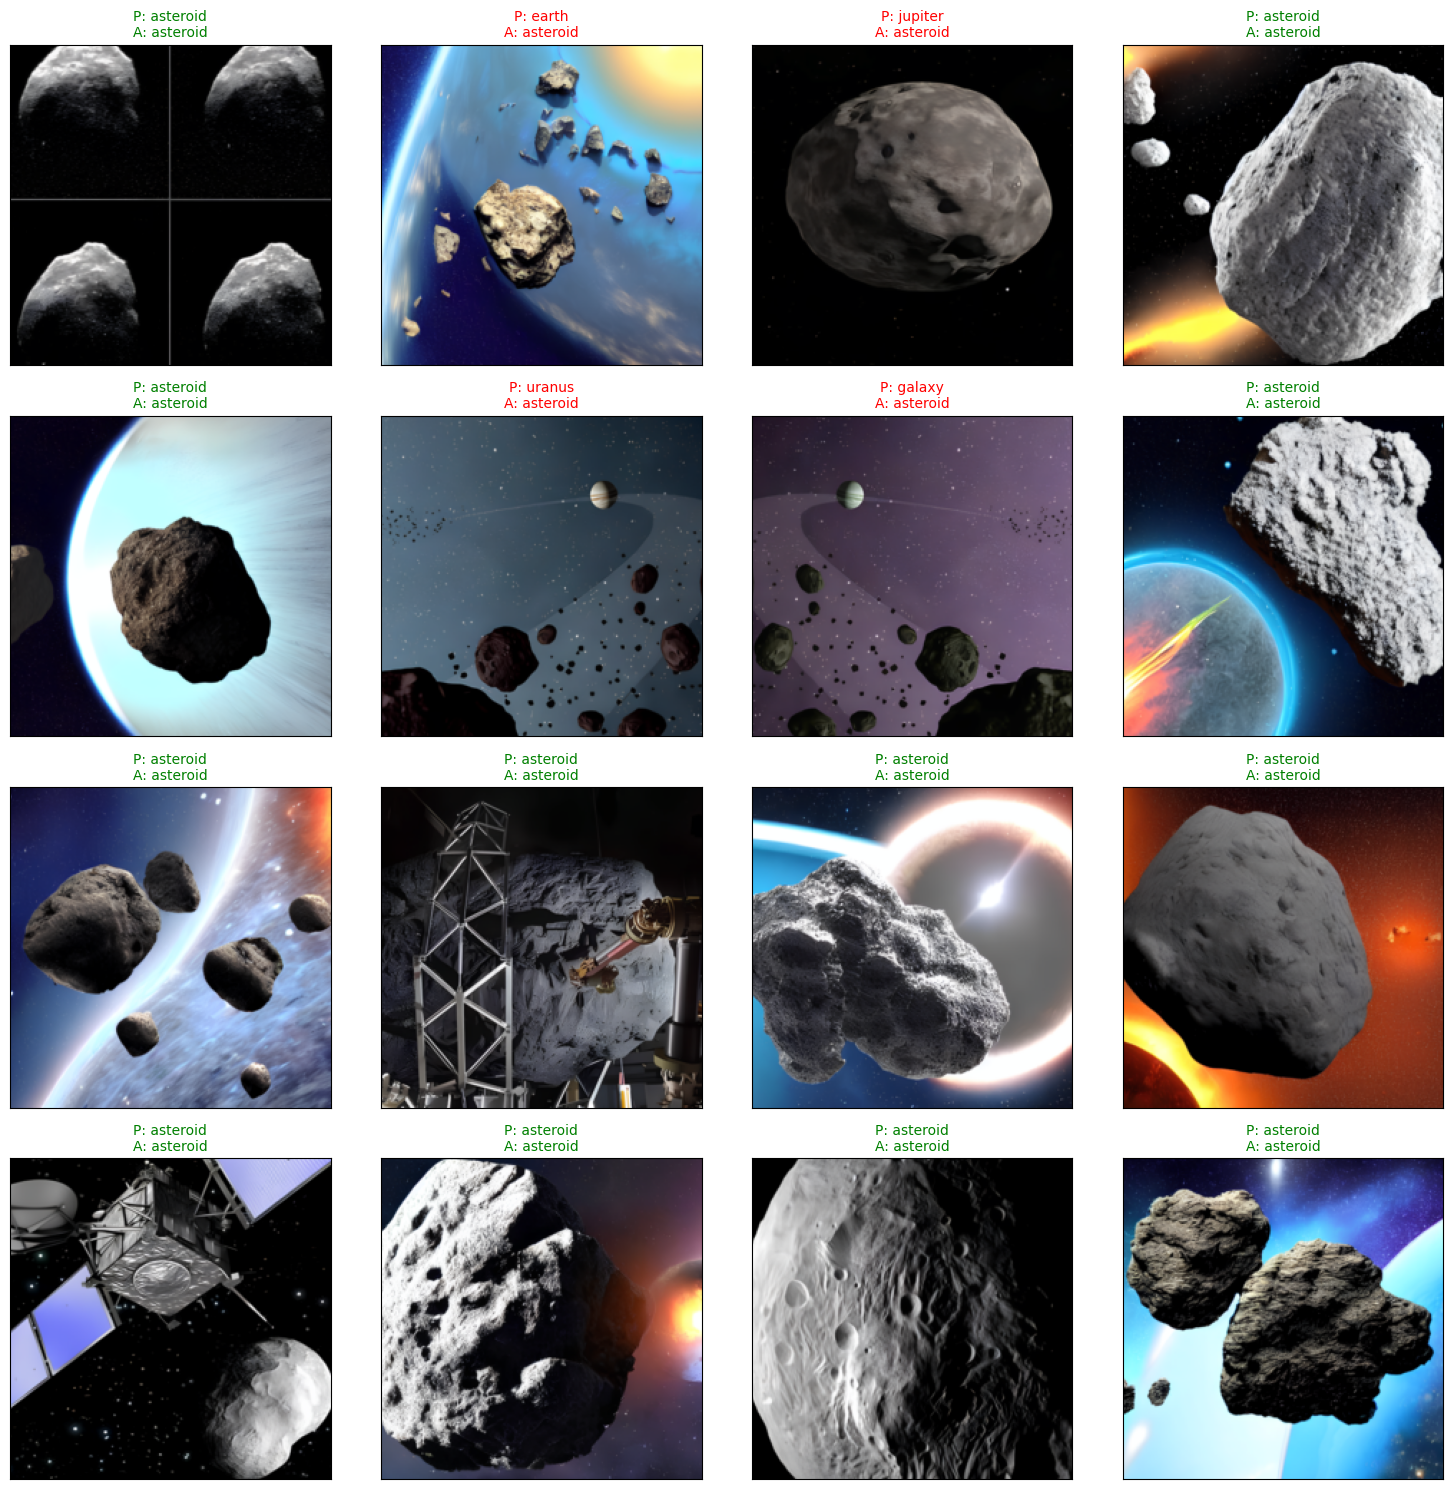

In [27]:
#Viewing a handful of images and the model predictions for them

# Function to get the class name from the index
def get_class_name(dataset, label_index):
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return idx_to_class[label_index]


images, actual_labels = next(iter(test_loader))
images_on_device = images.to(deviceLocal)
model.eval()
with torch.no_grad():
    outputs = model(images_on_device)

_, predicted_indices = torch.max(outputs.data, 1)

# Move tensors back to CPU for visualization
images = images.cpu()
actual_labels = actual_labels.cpu().numpy()
predicted_indices = predicted_indices.cpu().numpy()





# Denormalize the image tensor for display, reversing the transformations done originally
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Plot the first 16 images from the batch
fig = plt.figure(figsize=(15, 15))
subset_size = min(16, len(images))

for i in range(subset_size):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])

    # Get the predicted and actual class names
    predicted_class = get_class_name(test_loader.dataset, predicted_indices[i])
    actual_class = get_class_name(test_loader.dataset, actual_labels[i])

    # Checking if prediction is correct
    color = 'green' if predicted_class == actual_class else 'red'

    # Display the image
    ax.imshow(imshow(images[i]))

    # Set the title
    title = f'P: {predicted_class}\nA: {actual_class}'
    ax.set_title(title, color=color, fontsize=10)

plt.tight_layout()
plt.show()
